# 演示seq2seq lib中的beam search使用方法

In [3]:
import math
import numpy as np
import sys
import tensorflow as tf

# sys.path.append('C:\\Users\\reade\\Documents\\lecture4\\seq2seq')
sys.path.append('/Users/yuleinku/Google Drive/BOOK/聊天机器人Chatbot/lecture4/seq2seq')
from seq2seq.encoders import rnn_encoder
from seq2seq.decoders import (basic_decoder, beam_search_decoder)

# 产生/demo 合成数据

In [4]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 16

encoder_hidden_units = 32
decoder_hidden_units = encoder_hidden_units

import helpers as data_helpers
batch_size = 10

# 一个generator，每次产生一个minibatch的随机样本

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('产生%d个长度不一（最短3，最长8）的sequences, 其中前十个是:' % batch_size)
for seq in next(batches)[:min(batch_size, 10)]:
    print(seq)

产生10个长度不一（最短3，最长8）的sequences, 其中前十个是:
[4, 9, 2, 8, 6, 4, 9]
[2, 9, 5, 3, 6]
[2, 9, 9, 3, 6, 9, 8, 6]
[9, 4, 2, 6]
[6, 7, 6]
[3, 3, 3, 7, 7, 2, 7]
[7, 2, 8, 4]
[6, 8, 8, 5]
[8, 7, 5, 6]
[8, 9, 7, 5, 8, 9, 4, 6]


# 定义使用beamsearch decoder的seq2seq模型

### 声明placholder和定义encoder部分，同part2A

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
mode = tf.contrib.learn.ModeKeys.TRAIN

with tf.name_scope('minibatch'):
    encoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='encoder_inputs')
    encoder_inputs_length = tf.placeholder(shape=(None,),
                                           dtype=tf.int32,
                                           name='encoder_inputs_length')

    decoder_targets = tf.placeholder(shape=(None, None),
                                     dtype=tf.int32,
                                     name='decoder_targets')
    decoder_targets_length = tf.placeholder(shape=(None,),
                                            dtype=tf.int32,
                                            name='decoder_targets_length')
    
    decoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='decoder_inputs')
    decoder_inputs_length = tf.placeholder(shape=(None,),
                                            dtype=tf.int32,
                                            name='decoder_inputs_length')

    decoder_initial_state = tf.placeholder(shape=(None, None),
                                    dtype=tf.float32,
                                    name='decoder_initial_state')
    

# 2-a. 定义encoder
encoder_params = rnn_encoder.UnidirectionalRNNEncoder.default_params()
encoder_params["rnn_cell"]["cell_params"]["num_units"] = encoder_hidden_units
encoder_params["rnn_cell"]["cell_class"] = "BasicLSTMCell"
encoder_params  

# 2-b. 定义encoding过程
# 输入数据转化为embedding格式
with tf.name_scope('embedding'):
    input_embeddings = tf.Variable(
        tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
        dtype=tf.float32)
    output_embeddings = tf.Variable(
        tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
        dtype=tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(input_embeddings, encoder_inputs)

# 使用UnidirectionalRNNEncoder编码
encode_fn = rnn_encoder.UnidirectionalRNNEncoder(encoder_params, mode)
encoder_output = encode_fn(encoder_inputs_embedded, encoder_inputs_length)



INFO:tensorflow:Creating UnidirectionalRNNEncoder in mode=train
INFO:tensorflow:
UnidirectionalRNNEncoder:
  init_scale: 0.04
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 32}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



## 定义decoding模型，使用seq2seq.decoders.beam_search_decoder.BeamSearchDecoder
1. input embedding
2. helper <-- decoder_input, decoder_input_length
3. basic_decoder.BasicDecoder

### config decoder的选项，任何基于RNN的decoding操作都需要设定的超参数

In [6]:
decode_params = beam_search_decoder.BeamSearchDecoder.default_params()
decode_params["rnn_cell"]["cell_params"]["num_units"] = decoder_hidden_units
decode_params

{'init_scale': 0.04,
 'max_decode_length': 100,
 'rnn_cell': {'cell_class': 'BasicLSTMCell',
  'cell_params': {'num_units': 32},
  'dropout_input_keep_prob': 1.0,
  'dropout_output_keep_prob': 1.0,
  'num_layers': 1,
  'residual_combiner': 'add',
  'residual_connections': False,
  'residual_dense': False}}

### config beam_search的选项，即beam_search操作的超参数

* beam_width
* length_penalty_weight
* choose_successors_fn

In [7]:
from seq2seq.inference import beam_search
config = beam_search.BeamSearchConfig(
    beam_width = 10,
    vocab_size = vocab_size,
    eos_token = EOS,
    length_penalty_weight = 0.6,
    choose_successors_fn = beam_search.choose_top_k)

config

BeamSearchConfig(beam_width=10, vocab_size=10, eos_token=1, length_penalty_weight=0.6, choose_successors_fn=<function choose_top_k at 0x11f814488>)

In [8]:
from seq2seq.contrib.seq2seq import helper as decode_helper

In [9]:
beam_helper = decode_helper.GreedyEmbeddingHelper(
    embedding=output_embeddings,
    start_tokens=[0] * config.beam_width,
    end_token=-1)

decoder_fn = basic_decoder.BasicDecoder(params=decode_params,
                                       mode=mode,
                                       vocab_size=vocab_size)

"""
decoder_fn = create_decoder(
    helper=beam_helper,
    mode=tf.contrib.learn.ModeKeys.INFER)
"""
decoder_fn = beam_search_decoder.BeamSearchDecoder(
    decoder=decoder_fn,
    config=config)



INFO:tensorflow:Creating BasicDecoder in mode=train
INFO:tensorflow:
BasicDecoder:
  init_scale: 0.04
  max_decode_length: 100
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 32}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false

INFO:tensorflow:Creating BeamSearchDecoder in mode=train
INFO:tensorflow:
BeamSearchDecoder:
  init_scale: 0.04
  max_decode_length: 100
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 32}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



In [10]:
decoder_inputs_embedded = tf.nn.embedding_lookup(input_embeddings, decoder_inputs)

In [11]:
with tf.name_scope('minibatch'):
    helper = decode_helper.TrainingHelper(
        inputs = decoder_inputs_embedded,
        sequence_length = decoder_inputs_length)

In [12]:
decoder_fn = basic_decoder.BasicDecoder(params=decode_params,
                                       mode=mode,
                                       vocab_size=vocab_size)

INFO:tensorflow:Creating BasicDecoder in mode=train
INFO:tensorflow:
BasicDecoder:
  init_scale: 0.04
  max_decode_length: 100
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 32}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



In [13]:
decoder_output, decoder_state = decoder_fn(encoder_output.final_state, helper)

In [14]:

loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32), 
        logits=tf.transpose(decoder_output.logits, perm = [1, 0, 2]))
)
"""

# 通过阅读decoder_helper的定义，
# 输入数据是batch-major
# 而输出数据是time-major...
# 所以需要对输出的logits做一次transpose
# labels: [batch_size, max_length, vocab_size]
# logits （tranpose之前）: [max_length, batch_size, vocab_size] 
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits = tf.transpose(decoder_output.logits, perm=[1,0,2]), labels = decoder_targets))
"""

train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
def next_feed():
    batch = next(batches)
    
    encoder_inputs_, encoder_inputs_length_ = data_helpers.batch(batch)
    decoder_targets_, decoder_targets_length_ = data_helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, decoder_inputs_length_ = data_helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    
    # 在feedDict里面，key可以是一个Tensor
    return {
        encoder_inputs: encoder_inputs_.T,
        decoder_inputs: decoder_inputs_.T,
        decoder_targets: decoder_targets_.T,
        encoder_inputs_length: encoder_inputs_length_,
        decoder_inputs_length: decoder_inputs_length_,
        decoder_targets_length: decoder_targets_length_
    }

In [17]:
fd= next_feed()
fd

{<tf.Tensor 'minibatch/encoder_inputs:0' shape=(?, ?) dtype=int32>: array([[8, 6, 3, 7, 2, 2, 7],
        [5, 3, 9, 0, 0, 0, 0],
        [8, 8, 2, 0, 0, 0, 0],
        [9, 8, 8, 0, 0, 0, 0],
        [2, 5, 4, 8, 8, 3, 9],
        [7, 6, 4, 7, 9, 8, 4],
        [9, 9, 5, 7, 5, 4, 0],
        [8, 9, 7, 8, 2, 5, 6],
        [2, 3, 4, 5, 0, 0, 0],
        [2, 9, 2, 4, 0, 0, 0]], dtype=int32),
 <tf.Tensor 'minibatch/decoder_inputs:0' shape=(?, ?) dtype=int32>: array([[1, 8, 6, 3, 7, 2, 2, 7],
        [1, 5, 3, 9, 0, 0, 0, 0],
        [1, 8, 8, 2, 0, 0, 0, 0],
        [1, 9, 8, 8, 0, 0, 0, 0],
        [1, 2, 5, 4, 8, 8, 3, 9],
        [1, 7, 6, 4, 7, 9, 8, 4],
        [1, 9, 9, 5, 7, 5, 4, 0],
        [1, 8, 9, 7, 8, 2, 5, 6],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 9, 2, 4, 0, 0, 0]], dtype=int32),
 <tf.Tensor 'minibatch/decoder_targets:0' shape=(?, ?) dtype=int32>: array([[8, 6, 3, 7, 2, 2, 7, 1],
        [5, 3, 9, 1, 0, 0, 0, 0],
        [8, 8, 2, 1, 0, 0, 0, 0],
        [9, 8, 8

In [18]:
fd[encoder_inputs].shape

(10, 7)

In [19]:
fd[decoder_inputs].shape

(10, 8)

In [20]:
fd[decoder_targets].shape

(10, 8)

## 4. 我们已经定义了一个计算图
* 图的输入端是encoder_inputs 和 encoder_inputs_length
* 图的输出端是encoder_output

In [21]:
[encoder_out1, decoder_out1] = sess.run(
    [encoder_output, decoder_output], fd)


In [22]:
encoder_out1.outputs.shape

(10, 7, 32)

In [23]:
decoder_out1.cell_output.shape


(8, 10, 32)

In [24]:
decoder_out1.logits.shape

(8, 10, 10)

In [25]:
decoder_out1.predicted_ids.shape

(8, 10)

In [26]:
print('encoder output information:')
print(encoder_out1.outputs.shape)
print(encoder_out1.final_state.c.shape)
print(encoder_out1.final_state.h.shape)

encoder output information:
(10, 7, 32)
(10, 32)
(10, 32)


In [27]:
print('decoder output information:')
print(decoder_out1.predicted_ids.shape)

decoder output information:
(8, 10)


In [28]:
decoder_out1.predicted_ids.shape

(8, 10)

In [29]:
x = next_feed()
print('encoder_inputs:')
print(x[encoder_inputs][0,:])
print('decoder_inputs:')
print(x[decoder_inputs][0,:])
print('decoder_targets:')
print(x[decoder_targets][0,:])

encoder_inputs:
[5 4 6 3 4 5 2 6]
decoder_inputs:
[1 5 4 6 3 4 5 2 6]
decoder_targets:
[5 4 6 3 4 5 2 6 1]


In [30]:
def next_feed():
    batch = next(batches)
    
    encoder_inputs_, encoder_inputs_length_ = data_helpers.batch(batch)
    decoder_targets_, _ = data_helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, decoder_inputs_length_ = data_helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    
    # 在feedDict里面，key可以是一个Tensor
    return {
        encoder_inputs: encoder_inputs_.T,
        decoder_inputs: decoder_inputs_.T,
        decoder_targets: decoder_targets_.T,
        encoder_inputs_length: encoder_inputs_length_,
        decoder_inputs_length: decoder_inputs_length_
    }

batch_size = 100

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                        vocab_lower=2, vocab_upper=10,
                                        batch_size=batch_size)

print('产生100个长度不一的sequence')
print('其中前十个是:')
for seq in next(batches)[:10]:
    print(seq)
    
    


产生100个长度不一的sequence
其中前十个是:
[9, 6, 2, 9]
[3, 2, 4, 6, 6]
[4, 5, 4, 6]
[3, 6, 9, 2, 3, 8, 5]
[2, 7, 6]
[5, 2, 8]
[3, 6, 6, 4]
[4, 9, 8, 9, 6, 2, 8]
[2, 6, 2, 2]
[4, 9, 5, 7]


In [31]:
loss_track = []

max_batches = 3001
batches_in_epoch = 100

try:
    # 一个epoch的learning
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_output.predicted_ids, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs], predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
        
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.285630226135254
  sample 1:
    input     > [6 7 6 6 0 0 0 0]
    predicted > [8 6 6 6 6 6 0 0 0]
  sample 2:
    input     > [4 2 7 6 0 0 0 0]
    predicted > [7 7 5 9 6 9 0 0 0]
  sample 3:
    input     > [3 8 5 8 7 9 9 0]
    predicted > [9 9 9 9 2 0 9 9 0]

batch 100
  minibatch loss: 1.3210663795471191
  sample 1:
    input     > [7 9 5 5 6 5 0 0]
    predicted > [5 5 5 5 5 5 1 0 0]
  sample 2:
    input     > [3 2 8 4 7 5 0 0]
    predicted > [7 7 7 5 5 1 1 0 0]
  sample 3:
    input     > [6 9 4 8 9 9 6 3]
    predicted > [9 9 9 9 9 9 9 1 1]

batch 200
  minibatch loss: 0.865583062171936
  sample 1:
    input     > [5 8 6 2 9 6 0 0]
    predicted > [6 6 6 6 6 6 1 0 0]
  sample 2:
    input     > [9 8 5 8 0 0 0 0]
    predicted > [8 8 8 8 1 0 0 0 0]
  sample 3:
    input     > [9 5 7 4 4 5 4 5]
    predicted > [4 4 4 4 4 5 4 1 1]

batch 300
  minibatch loss: 0.6636637449264526
  sample 1:
    input     > [6 3 6 4 2 4 8 0]
    predicted > [6 3 4 4 4 4 

batch 2800
  minibatch loss: 0.05161980167031288
  sample 1:
    input     > [6 8 5 5 0 0 0 0]
    predicted > [6 8 5 5 1 0 0 0 0]
  sample 2:
    input     > [2 9 7 6 7 8 9 0]
    predicted > [2 9 7 6 7 8 9 1 0]
  sample 3:
    input     > [8 9 9 0 0 0 0 0]
    predicted > [8 9 9 1 0 0 0 0 0]

batch 2900
  minibatch loss: 0.06510461866855621
  sample 1:
    input     > [6 3 2 2 0 0 0 0]
    predicted > [6 3 2 2 1 0 0 0 0]
  sample 2:
    input     > [8 4 4 0 0 0 0 0]
    predicted > [8 4 4 1 0 0 0 0 0]
  sample 3:
    input     > [6 8 2 0 0 0 0 0]
    predicted > [6 8 2 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.04390644654631615
  sample 1:
    input     > [8 4 9 4 0 0 0 0]
    predicted > [8 4 9 4 1 0 0 0 0]
  sample 2:
    input     > [4 5 5 6 5 5 0 0]
    predicted > [4 5 5 6 5 5 1 0 0]
  sample 3:
    input     > [8 4 7 5 3 9 0 0]
    predicted > [8 4 7 5 3 9 1 0 0]



loss 0.0484 after 300100 examples (batch_size=100)


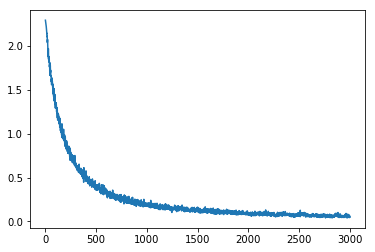

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))